# Predict the Presence of West-Nile-Virus-carrying Mosquitos

### by Team-MossKeyToes

## Problem Statement:
### Can the cases of West-Nile in Metro-Chicago be reduced (and the costs associated as a bonus) by strategically targeting the mosquito population in a preventative manner before they hit peak population?  How well can we train a model to balance correct predictions and misclassifications, and can its best results produce savings  - ROC AUC used to compare between models, weighted mispredictions used to evaluate unnecessary cost.

## Executive Summary:

## Notebook-1 (Data Cleaning and Processing)

   In this notebook we format and trim the weather data in a way that facilitates data manipulation in the modeling and analysis steps.  We use the data dictionary provided as a guide along the way.

## Import various code-function libraries and the weather data:

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [131]:
ps_w = pd.read_csv('../assets/weather.csv')

### Let's see the shape of the data and the head:

In [132]:
print('The file is organized into',ps_w.shape[0], 'rows and', ps_w.shape[1], 'columns.')
print('The number of null values is', ps_w.isnull().sum().sum(),'.')
ps_w.head(8).T

The file is organized into 2944 rows and 22 columns.
The number of null values is 0 .


,0,1,2,3,4,5,6,7
Station,1,2,1,2,1,2,1,2
Date,2007-05-01,2007-05-01,2007-05-02,2007-05-02,2007-05-03,2007-05-03,2007-05-04,2007-05-04
Tmax,83,84,59,60,66,67,66,78
Tmin,50,52,42,43,46,48,49,51
Tavg,67,68,51,52,56,58,58,M
Depart,14,M,-3,M,2,M,4,M
DewPoint,51,51,42,42,40,40,41,42
WetBulb,56,57,47,47,48,50,50,50
Heat,0,0,14,13,9,7,7,M
Cool,2,3,0,0,0,0,0,M


### There are no nulls counted, but we see many zeroes and "M" values and some "T" values.

In [133]:
ps_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


### The letter-values are why we see the datatypes of numeric features as text/string-object type.

### We see that 'Date' currently has type "object."  This is the most logical key for the dataset.  Converting the type to Date-time allows us to use built-in filtering.

In [134]:
ps_w['Date'] = ps_w['Date'].astype('datetime64')

In [135]:
ps_w = ps_w.set_index('Date')

In [136]:
ps_w.index.year.unique()

Int64Index([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], dtype='int64', name='Date')

In [137]:
max(ps_w.index)

Timestamp('2014-10-31 00:00:00')

### The data collected starts in May-2007 and extends to Oct-2014 for a total of eight seasons.

## "M" is for Missing Data.  Let’s take a look at how many M’s we have, and deal with these first.

In [138]:
(ps_w=='M').sum().sort_values(ascending=False)   

Water1         2944
SnowFall       1472
Depth          1472
Depart         1472
Tavg             11
Cool             11
Heat             11
SeaLevel          9
StnPressure       4
WetBulb           4
AvgSpeed          3
PrecipTotal       2
DewPoint          0
Tmax              0
Tmin              0
Sunset            0
Sunrise           0
ResultDir         0
CodeSum           0
ResultSpeed       0
Station           0
dtype: int64

### 'PrecipTotal' has the fewest missing values.  Let's start our missing-data handling there.

In [139]:
ps_w[ps_w['PrecipTotal']=="M"]

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-28,2,73,61,67,M,56,61,0,2,-,...,,M,M,M,M,29.43,30.07,12.2,2,13.3
2007-06-29,2,71,56,64,M,56,60,1,0,-,...,,M,M,M,M,29.47,30.11,7.4,2,8.2


### Let's look at the first row with a missing value, to see what data is found at the other station on the same date ("2007-07-28").  It's worth noting that these rows have multiple missing values.

In [140]:
ps_w[ps_w.index=="2007-06-28"]

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-28,1,74,58,66,-5,55,60,0,1,0419,...,,0,M,0.0,0.00,29.41,30.09,11.9,3,12.5
2007-06-28,2,73,61,67,M,56,61,0,2,-,...,,M,M,M,M,29.43,30.07,12.2,2,13.3


### Let's create a function that allows us to impute a missing value with the same value at the other station on the same date.  This is not a valid form of imputation by the way, but might be able to use it for up to the 11 values in a column where the M's are found.  (That 11-count works out to about up to 0.37%.)
#### This function should allow us to specify the DataFrame, the date, the feature-column and the station affected.

In [141]:
def impute_ems(df, impute_date, col, stn):
    if stn==1:
        row_num = ps_w[(ps_w.index==impute_date) & (ps_w.loc[:,'Station']==1)].index[0]
        ps_w.loc[row_num, col] = ps_w[(ps_w.index==impute_date) & 
                                                 (ps_w['Station']==2)][col].iloc[0]
    else:
        row_num = ps_w[(ps_w.index==impute_date) & (ps_w.loc[:,'Station']==2)].index[0]
        ps_w.loc[row_num, col] = ps_w[(ps_w.index==impute_date) & 
                                                 (ps_w['Station']==1)][col].iloc[0]

### Let's now use this function to impute numeric values for the Station-2 "M" values on the two dates of "2007-06-28" and "2007-06-29."

In [142]:
impute_ems(ps_w, '2007-06-28','PrecipTotal',2)
impute_ems(ps_w, '2007-06-29','PrecipTotal',2)

## Let's see how may "  T" values there are in the dataset.  The data dictionary from NOAA describes "T" as 'trace.'

In [143]:
(ps_w=='  T').sum().sort_values(ascending=False)   

PrecipTotal    318
SnowFall        12
AvgSpeed         0
Cool             0
Tmax             0
Tmin             0
Tavg             0
Depart           0
DewPoint         0
WetBulb          0
Heat             0
Sunset           0
Sunrise          0
ResultDir        0
CodeSum          0
Depth            0
Water1           0
StnPressure      0
SeaLevel         0
ResultSpeed      0
Station          0
dtype: int64

In [144]:
ps_w['PrecipTotal'].sort_values().unique()

array(['  T', '0.00', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06',
       '0.07', '0.08', '0.09', '0.10', '0.11', '0.12', '0.13', '0.14',
       '0.15', '0.16', '0.17', '0.18', '0.19', '0.20', '0.21', '0.22',
       '0.23', '0.24', '0.25', '0.26', '0.27', '0.28', '0.29', '0.30',
       '0.31', '0.32', '0.33', '0.34', '0.35', '0.36', '0.37', '0.38',
       '0.39', '0.40', '0.41', '0.42', '0.43', '0.44', '0.45', '0.46',
       '0.47', '0.48', '0.49', '0.50', '0.51', '0.52', '0.53', '0.54',
       '0.55', '0.56', '0.57', '0.58', '0.59', '0.60', '0.61', '0.62',
       '0.63', '0.64', '0.65', '0.66', '0.67', '0.68', '0.69', '0.70',
       '0.71', '0.72', '0.73', '0.74', '0.75', '0.76', '0.77', '0.78',
       '0.79', '0.80', '0.81', '0.82', '0.83', '0.84', '0.85', '0.86',
       '0.87', '0.88', '0.89', '0.90', '0.91', '0.92', '0.93', '0.95',
       '0.96', '0.97', '0.98', '1.01', '1.02', '1.03', '1.04', '1.05',
       '1.06', '1.07', '1.09', '1.11', '1.12', '1.14', '1.15', '1.16',
       

### Since 'trace' might mean amounts between "0.00" and "0.01," I decide that imputing "0.005" may not be too unreasonable.

In [145]:
mask_p = ps_w['PrecipTotal']=='  T'
ps_w['PrecipTotal'][mask_p] = '0.005'

/Users/perry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Let's move on to feature-column 'AvgSpeed' which has 3 "M" values.

In [146]:
ps_w[ps_w['AvgSpeed']=="M"]

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-13,2,86,68,77,M,53,62,0,12,-,...,,M,M,M,0.00,M,M,7.0,5,M
2011-09-14,2,60,48,54,M,45,51,11,0,-,...,RA BR HZ FU,M,M,M,0.005,29.47,M,6.0,32,M
2012-08-22,2,84,72,M,M,51,61,M,M,-,...,,M,M,M,0.00,29.39,M,4.7,19,M


In [147]:
impute_ems(ps_w, '2007-06-13','AvgSpeed',2)
impute_ems(ps_w, '2011-09-14','AvgSpeed',2)
impute_ems(ps_w, '2012-08-22','AvgSpeed',2)

## Next, 'WetBulb.'

In [148]:
ps_w[ps_w['WetBulb']=="M"]

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2009-06-26,1,86,69,78,7,60,M,0,13,0418,...,,0,M,0.0,0.00,M,29.85,6.4,4,8.2
2013-08-10,1,81,64,73,0,57,M,0,8,0454,...,,0,M,0.0,0.00,M,30.08,5.3,5,6.5
2013-08-11,1,81,60,71,-2,61,M,0,6,0455,...,RA,0,M,0.0,0.01,29.35,30.07,2.0,27,3.0
2013-08-12,2,85,69,77,M,63,M,0,12,-,...,RA,M,M,M,0.66,29.27,29.92,4.5,26,7.7


In [149]:
impute_ems(ps_w, '2009-06-26','WetBulb',1)
impute_ems(ps_w, '2013-08-10','WetBulb',1)
impute_ems(ps_w, '2013-08-11','WetBulb',1)
impute_ems(ps_w, '2013-08-12','WetBulb',2)

## Then, 'StnPressure.'

In [150]:
ps_w[ps_w['StnPressure']=="M"]

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-13,2,86,68,77,M,53,62,0,12,-,...,,M,M,M,0.00,M,M,7.0,5,8.6
2009-06-26,1,86,69,78,7,60,67,0,13,0418,...,,0,M,0.0,0.00,M,29.85,6.4,4,8.2
2013-08-10,1,81,64,73,0,57,63,0,8,0454,...,,0,M,0.0,0.00,M,30.08,5.3,5,6.5
2013-08-10,2,81,68,75,M,55,63,0,10,-,...,,M,M,M,0.00,M,30.07,6.0,6,7.4


### It looks like 'StnPressure' has "M" values at both stations...

In [151]:
impute_ems(ps_w, '2007-06-13','StnPressure',2)
impute_ems(ps_w, '2009-06-26','StnPressure',1)

### Let's look what the 'StnPressure' values are like on dates adjacent to "2013-08-10."

In [152]:
print(ps_w[ps_w.index=="2013-08-09"])
print(ps_w[ps_w.index=="2013-08-11"])

            Station  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
Date                                                                      
2013-08-09        1    82    59   71     -2        60      65    0    6   
2013-08-09        2    84    62   73      M        58      65    0    8   

           Sunrise    ...    CodeSum Depth Water1 SnowFall PrecipTotal  \
Date                  ...                                                
2013-08-09    0453    ...                0      M      0.0       0.005   
2013-08-09       -    ...                M      M        M        0.00   

           StnPressure SeaLevel ResultSpeed  ResultDir  AvgSpeed  
Date                                                              
2013-08-09       29.28    29.98         4.7         27       5.3  
2013-08-09       29.34    29.97         4.9         27       5.6  

[2 rows x 21 columns]
            Station  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
Date                                

### Let's also look at the 10-day trend centered on the 'StnPressure' values for the two stations separately.

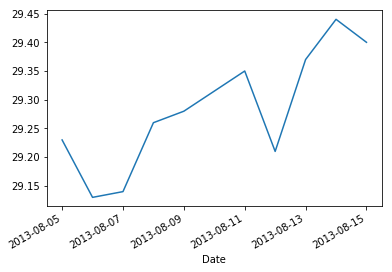

In [153]:
ps_w[(ps_w.index<='2013-08-15') &
     (ps_w.index>='2013-08-05') & (ps_w['Station']==1) &
     (ps_w['StnPressure']!='M')]['StnPressure'].astype('float64').plot()

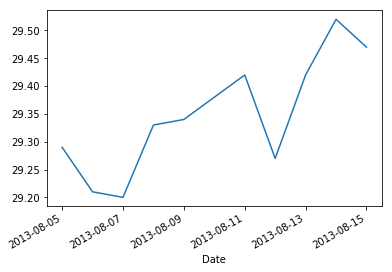

In [154]:
ps_w[(ps_w.index<='2013-08-15') &
     (ps_w.index>='2013-08-05') & (ps_w['Station']==2) &
     (ps_w['StnPressure']!='M')]['StnPressure'].astype('float64').plot()

#### The two pressure-value trends look closely correlated, but with distinct signatures at the two stations.  Let's impute the average of the 'StnPressure' values on adjacent dates.

In [175]:
ps_w.loc['2013-08-10','StnPressure']=[(29.28+29.35)/2,(29.34+29.42)/2]

In [178]:
ps_w.loc['2013-08-10','StnPressure']

Date
2013-08-10    29.315
2013-08-10     29.38
Name: StnPressure, dtype: object

### (Perhaps I should be imputing with averages of similarly-adjacent values instead of the opposite-station's values.  However, I decide that this may not provide a significant benefit on the scale of imputation that is required here.)

In [156]:
ps_w[ps_w['SeaLevel']=="M"]

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-13,2,86,68,77,M,53,62,0,12,-,...,,M,M,M,0.00,29.36,M,7.0,5,8.6
2009-06-18,1,80,61,71,1,63,67,0,6,0416,...,RA BR,0,M,0.0,0.12,29.08,M,6.7,16,7.9
2009-09-07,1,77,59,68,1,59,62,0,3,0523,...,BR,0,M,0.0,0.00,29.39,M,5.8,3,4.0
2011-09-08,1,75,57,66,0,53,59,0,1,0524,...,RA,0,M,0.0,0.005,29.34,M,13.0,2,13.4
2011-09-14,2,60,48,54,M,45,51,11,0,-,...,RA BR HZ FU,M,M,M,0.005,29.47,M,6.0,32,7.3
2011-09-20,1,74,49,62,0,54,58,3,0,0537,...,MIFG BCFG BR,0,M,0.0,0.00,29.26,M,7.3,18,7.3
2012-08-22,2,84,72,M,M,51,61,M,M,-,...,,M,M,M,0.00,29.39,M,4.7,19,5.8
2012-09-03,1,88,71,80,12,70,73,0,15,0519,...,BR,0,M,0.0,0.00,29.17,M,4.6,6,4.4
2014-07-23,2,76,64,70,M,56,61,0,5,-,...,,M,M,M,0.00,29.47,M,16.4,2,16.7


In [157]:
impute_ems(ps_w, '2007-06-13','SeaLevel',2)
impute_ems(ps_w, '2009-06-18','SeaLevel',1)
impute_ems(ps_w, '2009-09-07','SeaLevel',1)
impute_ems(ps_w, '2011-09-08','SeaLevel',1)
impute_ems(ps_w, '2011-09-14','SeaLevel',2)
impute_ems(ps_w, '2011-09-20','SeaLevel',1)
impute_ems(ps_w, '2012-08-22','SeaLevel',2)
impute_ems(ps_w, '2012-09-03','SeaLevel',1)
impute_ems(ps_w, '2014-07-23','SeaLevel',2)

## Now, for the 'Cool' feature-column's "M" values: (Described as the 'cooling season' in the NOAA data dictionary.

In [158]:
print(ps_w['Cool'].unique())
ps_w[ps_w['Cool']=="M"]

[' 2' ' 3' ' 0' 'M' ' 5' ' 4' ' 6' ' 8' ' 7' ' 9' '10' '13' '11' '12' ' 1'
 '15' '16' '17' '14' '20' '19' '18' '21' '22' '24' '27' '23' '26' '28'
 '29' '25']


,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-04,2,78,51,M,M,42,50,M,M,-,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
2008-07-08,2,86,46,M,M,68,71,M,M,-,...,TS RA,M,M,M,0.28,29.16,29.80,7.4,24,8.3
2008-10-01,2,62,46,M,M,41,47,M,M,-,...,,M,M,M,0.00,29.30,29.96,10.9,33,11.0
2011-07-22,2,100,71,M,M,70,74,M,M,-,...,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.8,10,8.2
2012-08-22,2,84,72,M,M,51,61,M,M,-,...,,M,M,M,0.00,29.39,30.07,4.7,19,5.8
2013-05-02,2,71,42,M,M,39,45,M,M,-,...,,M,M,M,0.00,29.51,30.17,15.8,2,16.1
2013-09-24,2,91,52,M,M,48,54,M,M,-,...,,M,M,M,0.00,29.33,30.00,5.8,9,7.7
2013-09-29,2,84,53,M,M,48,54,M,M,-,...,RA BR,M,M,M,0.22,29.36,30.01,6.3,36,7.8
2013-10-06,2,76,48,M,M,44,50,M,M,-,...,RA DZ BR,M,M,M,0.06,29.10,29.76,10.1,25,10.6


### Note: All the missing 'Cool' values are found at Station-2.  Let's look at the 14-day trend centered around the missing value on "2008-07-08."

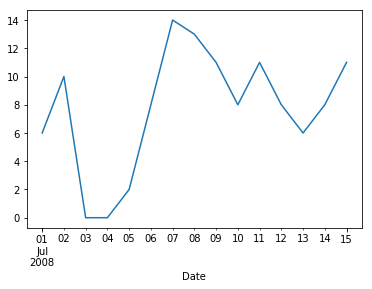

In [159]:
ps_w[(ps_w.index>='2008-07-01') &
     (ps_w.index<='2008-07-15') & (ps_w['Station']==1) &
     (ps_w['Cool']!='M')]['Cool'].astype('int').plot()

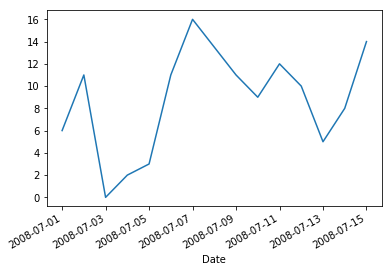

In [160]:
ps_w[(ps_w.index>='2008-07-01') &
     (ps_w.index<='2008-07-15') & (ps_w['Station']==2) &
     (ps_w['Cool']!='M')]['Cool'].astype('int').plot()

#### I am interested in seeing the global trend in the 'Cool' feature-column and look at the plots from Station-1.

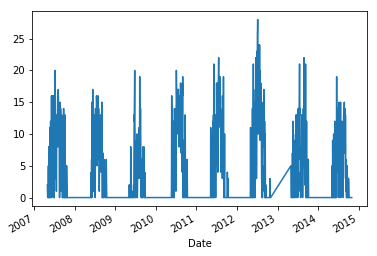

In [161]:
ps_w[ps_w['Station']==1]['Cool'].astype(int).plot()

#### After checking value-trends adjacent to May-04-2007 and July-08-2008, I decide to proceed with using our function that imputes values from the opposing station.

In [162]:
impute_ems(ps_w, '2007-05-04','Cool',2)
impute_ems(ps_w, '2008-07-08','Cool',2)
impute_ems(ps_w, '2008-10-01','Cool',2)
impute_ems(ps_w, '2011-07-22','Cool',2)
impute_ems(ps_w, '2012-08-22','Cool',2)
impute_ems(ps_w, '2013-05-02','Cool',2)
impute_ems(ps_w, '2013-09-24','Cool',2)
impute_ems(ps_w, '2013-09-29','Cool',2)
impute_ems(ps_w, '2013-10-06','Cool',2)
impute_ems(ps_w, '2014-05-02','Cool',2)
impute_ems(ps_w, '2014-08-26','Cool',2)

#### We can look at the global trend in the 'Cool' feature-column from Station-2 as well now.

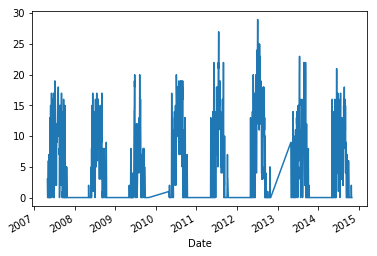

In [163]:
ps_w[ps_w['Station']==2]['Cool'].astype(int).plot()

#### It looks well-correlated overall, which is encouraging.

### Now, for 'Heat' or the 'heating season' as referred to in the NOAA-dictionary.

In [164]:
print(ps_w['Heat'].unique())
ps_w[ps_w['Heat']=="M"]

['0' '14' '13' '9' '7' 'M' '5' '6' '4' '10' '8' '12' '3' '2' '1' '15' '16'
 '19' '17' '20' '11' '18' '21' '25' '24' '27' '26' '23' '28' '22' '29']


,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-04,2,78,51,M,M,42,50,M,0,-,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
2008-07-08,2,86,46,M,M,68,71,M,13,-,...,TS RA,M,M,M,0.28,29.16,29.80,7.4,24,8.3
2008-10-01,2,62,46,M,M,41,47,M,0,-,...,,M,M,M,0.00,29.30,29.96,10.9,33,11.0
2011-07-22,2,100,71,M,M,70,74,M,14,-,...,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.8,10,8.2
2012-08-22,2,84,72,M,M,51,61,M,5,-,...,,M,M,M,0.00,29.39,30.07,4.7,19,5.8
2013-05-02,2,71,42,M,M,39,45,M,0,-,...,,M,M,M,0.00,29.51,30.17,15.8,2,16.1
2013-09-24,2,91,52,M,M,48,54,M,0,-,...,,M,M,M,0.00,29.33,30.00,5.8,9,7.7
2013-09-29,2,84,53,M,M,48,54,M,0,-,...,RA BR,M,M,M,0.22,29.36,30.01,6.3,36,7.8
2013-10-06,2,76,48,M,M,44,50,M,0,-,...,RA DZ BR,M,M,M,0.06,29.10,29.76,10.1,25,10.6


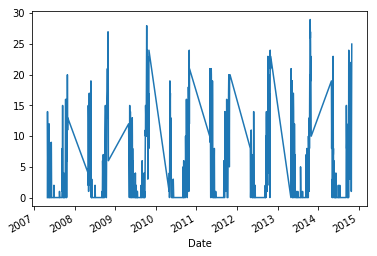

In [166]:
ps_w[ps_w['Station']==1]['Heat'].astype(int).plot()

#### Again, all the missing values are found at Station-2.  Also, we see above the overall trend observed for 'Heat' at Station-1.  Let's go ahead with the similar imputations.

In [167]:
impute_ems(ps_w, '2007-05-04','Heat',2)
impute_ems(ps_w, '2008-07-08','Heat',2)
impute_ems(ps_w, '2008-10-01','Heat',2)
impute_ems(ps_w, '2011-07-22','Heat',2)
impute_ems(ps_w, '2012-08-22','Heat',2)
impute_ems(ps_w, '2013-05-02','Heat',2)
impute_ems(ps_w, '2013-09-24','Heat',2)
impute_ems(ps_w, '2013-09-29','Heat',2)
impute_ems(ps_w, '2013-10-06','Heat',2)
impute_ems(ps_w, '2014-05-02','Heat',2)
impute_ems(ps_w, '2014-08-26','Heat',2)

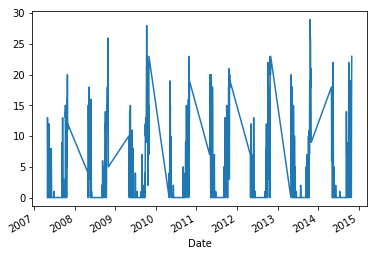

In [168]:
ps_w[ps_w['Station']==2]['Heat'].astype(int).plot()

## Next up, is 'Tavg.'

In [169]:
ps_w[ps_w['Tavg']=="M"]

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-04,2,78,51,M,M,42,50,7,0,-,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
2008-07-08,2,86,46,M,M,68,71,0,13,-,...,TS RA,M,M,M,0.28,29.16,29.80,7.4,24,8.3
2008-10-01,2,62,46,M,M,41,47,11,0,-,...,,M,M,M,0.00,29.30,29.96,10.9,33,11.0
2011-07-22,2,100,71,M,M,70,74,0,14,-,...,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.8,10,8.2
2012-08-22,2,84,72,M,M,51,61,0,5,-,...,,M,M,M,0.00,29.39,30.07,4.7,19,5.8
2013-05-02,2,71,42,M,M,39,45,16,0,-,...,,M,M,M,0.00,29.51,30.17,15.8,2,16.1
2013-09-24,2,91,52,M,M,48,54,5,0,-,...,,M,M,M,0.00,29.33,30.00,5.8,9,7.7
2013-09-29,2,84,53,M,M,48,54,5,0,-,...,RA BR,M,M,M,0.22,29.36,30.01,6.3,36,7.8
2013-10-06,2,76,48,M,M,44,50,10,0,-,...,RA DZ BR,M,M,M,0.06,29.10,29.76,10.1,25,10.6


### We see that all the "M" values are found at Station-2.  The best approach here is to calculate the sum of 'Tmin' and 'Tmax,' rounded appropriately to the nearest degree.  (We should really be coding a for-loop here.)

In [180]:
ps_w.loc['2007-05-04','Tavg'][1] = (ps_w.loc['2007-05-04','Tmin'][1] + ps_w.loc['2007-05-04','Tmax'][1] -1) / 2
ps_w.loc['2008-07-08','Tavg'][1] = (ps_w.loc['2008-07-08','Tmin'][1] + ps_w.loc['2008-07-08','Tmax'][1]) / 2
ps_w.loc['2008-10-01','Tavg'][1] = (ps_w.loc['2008-10-01','Tmin'][1] + ps_w.loc['2008-10-01','Tmax'][1]) / 2
ps_w.loc['2011-07-22','Tavg'][1] = (ps_w.loc['2011-07-22','Tmin'][1] + ps_w.loc['2011-07-22','Tmax'][1] +1) / 2
ps_w.loc['2012-08-22','Tavg'][1] = (ps_w.loc['2012-08-22','Tmin'][1] + ps_w.loc['2012-08-22','Tmax'][1]) / 2
ps_w.loc['2013-05-02','Tavg'][1] = (ps_w.loc['2013-05-02','Tmin'][1] + ps_w.loc['2013-05-02','Tmax'][1] -1) / 2
ps_w.loc['2013-09-24','Tavg'][1] = (ps_w.loc['2013-09-24','Tmin'][1] + ps_w.loc['2013-09-24','Tmax'][1] +1) / 2
ps_w.loc['2013-09-29','Tavg'][1] = (ps_w.loc['2013-09-29','Tmin'][1] + ps_w.loc['2013-09-29','Tmax'][1] -1) / 2
ps_w.loc['2013-10-06','Tavg'][1] = (ps_w.loc['2013-10-06','Tmin'][1] + ps_w.loc['2013-10-06','Tmax'][1]) / 2
ps_w.loc['2014-05-02','Tavg'][1] = (ps_w.loc['2014-05-02','Tmin'][1] + ps_w.loc['2014-05-02','Tmax'][1] +1) / 2
ps_w.loc['2014-08-26','Tavg'][1] = (ps_w.loc['2014-08-26','Tmin'][1] + ps_w.loc['2014-08-26','Tmax'][1] +1) / 2

/Users/perry/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Let's check the results:

In [184]:
print(ps_w.loc['2007-05-04','Tavg'][1])
print(ps_w.loc['2008-07-08','Tavg'][1])
print(ps_w.loc['2008-10-01','Tavg'][1])
print(ps_w.loc['2011-07-22','Tavg'][1])
print(ps_w.loc['2012-08-22','Tavg'][1])
print(ps_w.loc['2013-05-02','Tavg'][1])
print(ps_w.loc['2013-09-24','Tavg'][1])
print(ps_w.loc['2013-09-29','Tavg'][1])
print(ps_w.loc['2013-10-06','Tavg'][1])
print(ps_w.loc['2014-05-02','Tavg'][1])
print(ps_w.loc['2014-08-26','Tavg'][1])

64.0
66.0
54.0
86.0
78.0
56.0
72.0
68.0
62.0
64.0
68.0


In [185]:
print(ps_w['Depth'].unique())

['0' 'M']


#### There doesn't appear to be any information in the 'Depth' feature-column.  Also, 'Water1' feature-column has only "M" values.

## Therefore, it is safe to simply delete columns 'Depth and 'Water1.'

In [186]:
ps_w.drop('Depth', axis=1, inplace=True)
ps_w.drop('Water1', axis=1, inplace=True)

### Next, the 'Depart' feature-column has only recorded "M" values from Station-2, so it may not be worth making any imputation there.  We might just call the values recorded at Station-1, if needed.  Below, let's plot the overall trend for 'Depart' from Station-1:

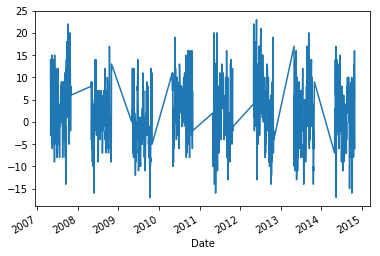

In [188]:
ps_w[ps_w['Station']==1]['Depart'].astype(int).plot()

## Now, we can turn our attention to the 'Sunrise' and 'Sunset' feature-columns:

In [189]:
(ps_w=='-').sum().sort_values(ascending=False)   

Sunrise        1472
Sunset         1472
Cool              0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           0
Heat              0
AvgSpeed          0
ResultDir         0
CodeSum           0
SnowFall          0
PrecipTotal       0
StnPressure       0
SeaLevel          0
ResultSpeed       0
Station           0
dtype: int64

In [190]:
print(ps_w[ps_w['Station']==2]['Sunrise'].unique())
print(ps_w[ps_w['Station']==2]['Sunset'].unique())

['-']
['-']


### We have a similar situation for 'Sunrise' and 'Sunset' with missing values from Station-2.  However, the "-" character is used to indicate missing values.

### We might just again call the values recorded at Station-1, if needed. Below, let's plot the overall trend for 'Sunrise' and 'Sunset' from Station-1:

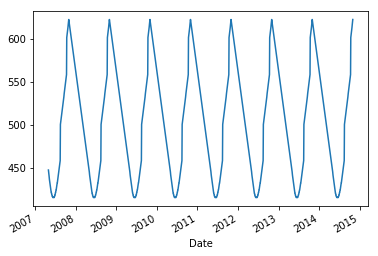

In [191]:
ps_w[ps_w['Station']==1]['Sunrise'].astype(int).plot()

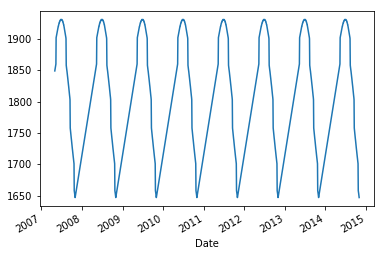

In [192]:
ps_w[ps_w['Station']==1]['Sunset'].astype(int).plot()

## Now, for 'SnowFall:'

In [67]:
print(ps_w[ps_w['Station']==2]['SnowFall'].value_counts())
ps_w[ps_w['Station']==1]['SnowFall'].value_counts()

M    1472
Name: SnowFall, dtype: int64


0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

### "T" is for 'trace.'  We could impute "0.05" for these in the 'SnowFall' feature-column.  However, it may not hold any significance, given that mosquitos hibernate in the winter.

## In summary, we see no need to impute for Station-2's missing 'Depart,' 'SnowFall,' 'Sunrise' and 'Sunset' values.

## Now, with the missing values handled, we can convert string-types for our numeric columns:

In [193]:
ps_w['Tavg'] = ps_w['Tavg'].astype(int)
ps_w['WetBulb'] = ps_w['WetBulb'].astype(int)
ps_w['Heat'] = ps_w['Heat'].astype(int)
ps_w['Cool'] = ps_w['Cool'].astype(int)
ps_w['PrecipTotal'] = ps_w['PrecipTotal'].astype(np.float64)
ps_w['StnPressure'] = ps_w['StnPressure'].astype(np.float64)
ps_w['SeaLevel'] = ps_w['SeaLevel'].astype(np.float64)
ps_w['AvgSpeed'] = ps_w['AvgSpeed'].astype(np.float64)

In [194]:
ps_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 19 columns):
Station        2944 non-null int64
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null int64
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null int64
Heat           2944 non-null int64
Cool           2944 non-null int64
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null float64
StnPressure    2944 non-null float64
SeaLevel       2944 non-null float64
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null float64
dtypes: float64(5), int64(9), object(5)
memory usage: 540.0+ KB


In [74]:
ps_w.describe().T

,count,mean,std,min,25%,50%,75%,max
Station,2944.0,1.500000,0.500085,1.00,1.00,1.50,2.00,2.00
Tmax,2944.0,76.166101,11.461970,41.00,69.00,78.00,85.00,104.00
Tmin,2944.0,57.810462,10.381939,29.00,50.00,59.00,66.00,83.00
Tavg,2944.0,67.239470,10.539316,36.00,60.00,69.00,75.00,94.00
DewPoint,2944.0,53.457880,10.675181,22.00,46.00,54.00,62.00,75.00
WetBulb,2944.0,59.319293,9.283540,32.00,53.00,61.00,67.00,78.00
Heat,2944.0,3.417799,5.955153,0.00,0.00,0.00,5.00,29.00
Cool,2944.0,5.641304,6.104849,0.00,0.00,4.00,10.00,29.00
PrecipTotal,2944.0,0.131780,0.393031,0.00,0.00,0.00,0.06,6.86
StnPressure,2944.0,29.284468,0.158460,28.55,29.19,29.28,29.39,29.86


## We can look a some distributions for these numeric columns now, without the issue of missing values.

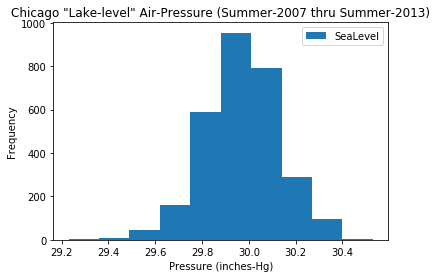

In [201]:
plt.figure(); ps_w['SeaLevel'].plot(kind='hist'); plt.xlabel("Pressure (inches-Hg)");plt.title('Chicago "Lake-level" Air-Pressure (Summer-2007 thru Summer-2013)'); plt.legend()

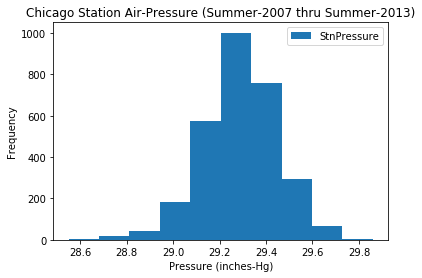

In [200]:
plt.figure(); ps_w['StnPressure'].plot(kind='hist'); plt.xlabel("Pressure (inches-Hg)");plt.title('Chicago Station Air-Pressure (Summer-2007 thru Summer-2013)'); plt.legend()

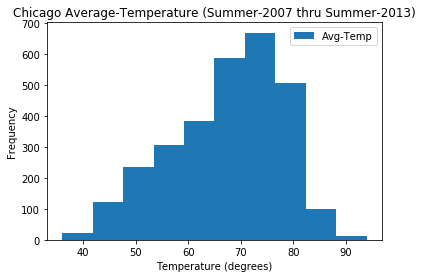

In [198]:
plt.figure(); ps_w['Tavg'].plot(kind='hist', label='Avg-Temp'); plt.xlabel("Temperature (degrees)");plt.title('Chicago Average-Temperature (Summer-2007 thru Summer-2013)'); plt.legend()

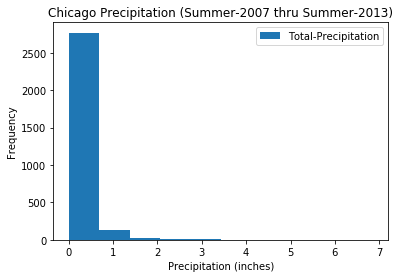

In [202]:
plt.figure(); ps_w['PrecipTotal'].plot(kind='hist', label='Total-Precipitation'); plt.xlabel("Precipitation (inches)");plt.title('Chicago Precipitation (Summer-2007 thru Summer-2013)'); plt.legend()

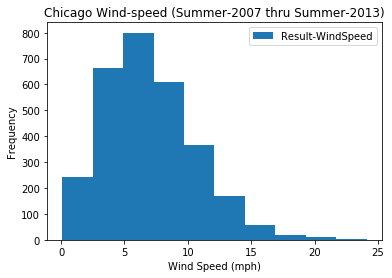

In [203]:
plt.figure(); ps_w['ResultSpeed'].plot(kind='hist', label='Result-WindSpeed'); plt.xlabel("Wind Speed (mph)");plt.title('Chicago Wind-speed (Summer-2007 thru Summer-2013)'); plt.legend()

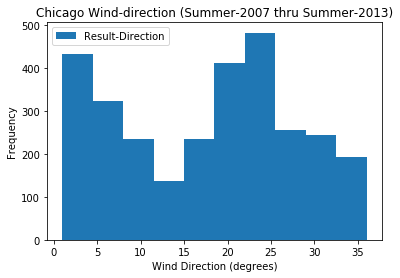

In [204]:
plt.figure(); ps_w['ResultDir'].plot(kind='hist', label='Result-Direction'); plt.xlabel("Wind Direction (degrees)");plt.title('Chicago Wind-direction (Summer-2007 thru Summer-2013)'); plt.legend()

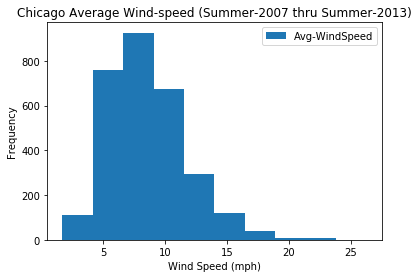

In [205]:
plt.figure(); ps_w['AvgSpeed'].plot(kind='hist', label='Avg-WindSpeed'); plt.xlabel("Wind Speed (mph)");plt.title('Chicago Average Wind-speed (Summer-2007 thru Summer-2013)'); plt.legend()

## Finally, there is a 'CodeSum' feature-column providing information on various weather phenomena observed.  The incidence of rain should be noted, so we can add a column reflecting this condition and see if the incidences are comparable between the two stations:

In [207]:
ps_w['isRain'] = np.where(ps_w['CodeSum'].str.contains('RA'), 1, 0)

In [208]:
print(ps_w[ps_w['Station']==1]['isRain'].sum())
print(ps_w[ps_w['Station']==2]['isRain'].sum())

524
511


### Look at the processing results to check that the data is ready one last time before recording the results for the next steps.

In [209]:
ps_w.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,isRain
Date,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,1849,,0.0,0.0,29.10,29.82,1.7,27,9.2,0
2007-05-01,2,84,52,68,M,51,57,0,3,-,-,,M,0.0,29.18,29.82,2.7,25,9.6,0
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,1850,BR,0.0,0.0,29.38,30.09,13.0,4,13.4,0
2007-05-02,2,60,43,52,M,42,47,13,0,-,-,BR HZ,M,0.0,29.44,30.08,13.3,2,13.4,0
2007-05-03,1,66,46,56,2,40,48,9,0,0446,1851,,0.0,0.0,29.39,30.12,11.7,7,11.9,0


### Save the processed data for modeling and analysis.  
#### (Saving the preprocessing results means that there is a reproducible starting point for subsequent work, but also ensures that  the processed data does not need to be re-run going forwards.)

In [133]:
ps_w.to_csv('../assets/ps_weather_processed.csv')

## Next Step:

   With the weather data in the appropriate datatypes, the missing-data handled, DataFrame-index set, features lacking information removed and the resulting data saved, we are able to integrate it with the "train" and/or "spray" data.

# Continued on Notebook-2 (Data Exploration)